In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
from scipy.stats import mode

In [6]:
tf.keras.config.enable_unsafe_deserialization()
seg_unet = tf.keras.models.load_model('segmentation.keras')


In [53]:
def binar(image ): 
    imgregion=np.zeros_like(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    #u-net segmentattion        
    size=128
    image_stack = []
    tmp = cv2.resize(image, (size, size))                
    image_stack.append(tmp)
    image_stack.append(np.zeros_like(tmp))           
    image_stack=np.array(image_stack)
    image_stack = image_stack.astype('float32') / 255.0
    seg=seg_unet.predict(image_stack)
    seg = cv2.resize(seg[0], (250, 250))
    seg = (seg * 255).astype(np.uint8)

    ret, imgbin = cv2.threshold(seg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    edges = cv2.Canny(imgbin, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(imgregion, contours, -1, 255, thickness=cv2.FILLED)
    

    return imgbin,imgregion

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


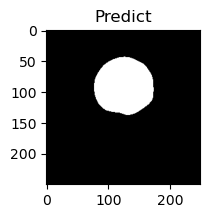

In [54]:
img = cv2.imread("Daten/"+ str('l') + "/" + str(1) + ".png")
x, y, crop_size = 615, 380, 250 #größe und position
crop = img[y:y+crop_size, x:x+crop_size].copy()
imgbin, imgregion = binar(crop)
imgbin.shape
plt.figure(figsize=(2, 2))
plt.imshow(imgregion)
plt.title("Predict")
plt.gray()


In [77]:
tf.keras.config.enable_unsafe_deserialization()
seg_unet = tf.keras.models.load_model('segmentation.keras')

class Bildverarbeitung:
    def __init__(self, Img, auto):
        # Bilder
        try:
            self.img = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)

        except:
            self.img = Img

        self.img_shadow_re = self.img.copy()

        #finden der region of interest / bauteil
        x, y, crop_size = 615, 380, 250 #größe und position
        self.crop = self.img[y:y+crop_size, x:x+crop_size].copy()

        self.imgbin = np.zeros_like(self.crop)
        self.imgregion = np.zeros_like(self.crop)
        

        self.emty = np.zeros_like(self.crop)
        self.countur_img = cv2.cvtColor(self.crop, cv2.COLOR_GRAY2BGR)
        self.aussenkontur_img = np.zeros_like(self.crop)
        self.edges = np.zeros_like(self.crop)
        self.imgclean = self.crop.copy()
        self.weisserstrich= self.crop.copy()

        self.auto=auto

        # Daten
        self.flaechemittekoor = np.zeros(2)
        self.weisserstrichkoor = np.zeros(2) 
        self.mittekoor = np.zeros(2)
        self.flaeche = -1
        self.max_grad = -1
        self.dis_grad = np.zeros(50)
        self.dis_camera = -1
        self.metadata = "Emty"
        self.max_radius = 1000
        self.min_radius=0
        self.median_radius=0
        self.mittelwert_radius=0
        self.var_radius=0
        self.data=np.zeros(22) #Fläche, max_grad, min_grad, var Grad, mittel Grad, median Grad, rundheit, dis fl. mitte zur mitte, winkel weis, d1 , d2 ,d3 
        

        # Error
        self.error = "Erros: "
        

    def binar(self, vis=False): 
        global count
        rio= self.crop.copy()
 
        
        #u-net segmentattion        
        size=128
        image_stack = []
        tmp = cv2.cvtColor(rio, cv2.COLOR_GRAY2BGR)
        tmp = cv2.resize(tmp, (size, size))                
        image_stack.append(tmp)
        image_stack.append(np.zeros_like(tmp))           
        image_stack=np.array(image_stack)
        print(image_stack[0].shape)
        image_stack = image_stack.astype('float32') / 255.0
        seg=seg_unet.predict(image_stack)
        seg = cv2.resize(seg[0], (250, 250))
        seg = (seg * 255).astype(np.uint8)

        ret, imgbin = cv2.threshold(seg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        edges = cv2.Canny(imgbin, 50, 150)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(imgregion, contours, -1, 255, thickness=cv2.FILLED)

        
    def reduce_shadows(self, alpha, beta):
        # Increase the image contrast
        adjusted_image = cv2.convertScaleAbs(self.img, alpha=alpha, beta=beta)

        # Clip pixel values to be in the valid range [0, 255]
        self.img_shadow_re = np.clip(adjusted_image, 0, 255)
        self.img = self.img_shadow_re.copy()

    def angle_between_vectors(self,v1, v2):
        dot_product = np.dot(v1, v2)
        magnitude_v1 = np.linalg.norm(v1)
        magnitude_v2 = np.linalg.norm(v2)
        cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
        angle_radians = np.arccos(cos_theta)
        angle_degrees = np.degrees(angle_radians)
        return angle_degrees

    def plot_histogram(self, gray_img):
        # Calculate histogram
        histogram = cv2.calcHist([gray_img], [0], None, [256], [0, 256])

        # Plot histogram
        plt.figure()
        plt.title("Grayscale Image Histogram")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.plot(histogram, color='black')
        plt.xlim([0, 256])
        plt.show()


def image_it(i, data, l_r, auto=False, speicher_img=False, vis=False, speichern_data=False):
    img = cv2.imread("Daten/"+ str(l_r) + "/" + str(i+1) + ".png")
    img = Bildverarbeitung(img, auto)
    img.reduce_shadows(1.2, 5) 
    img.binar()
    

    if speichern_data:
        data = img.data
        del img
        return data
    del img

def main():
    #variables
    l_r = 'r'
    size=10
    speichern_csv_excel= False

    #data
    data_recieved=False
    data=np.zeros((size,22))
    index=np.arange(1,size+1,1)
    labels= ['A','max Grad', 'min Grad', 'Var Grad', 'mittel Grad', 'median Grad', 'modus Grad', 'Rundheit', 'Umfang', 'Bauteil koor. x', 'Bauteil koor. y', 'Flächenmitte koor. x', 'Flächenmitte koor. y', 'Weißerstrich koor. x', 'Weißerstrich koor. y','delta FB','delta WB','delta FW', 'Winkel Weiß zu Max', 'd1', 'd2', 'd3']
    for i in range(size):
        try:
            print('###################################' + str(i+1)+ '########################################')
            data[i,:] = image_it(i,data,l_r,auto= False, vis=False, speicher_img=True, speichern_data=False)
            data_recieved=True
        except:
            print('Bild ' + str(i+1) + " nicht gefunden")
            raise ValueError()



In [78]:


main()


###################################1########################################
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
###################################2########################################
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
###################################3########################################
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
###################################4########################################
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
###################################5########################################
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
###################################6########################################
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
###################################7########################################
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
###################################8########################################
(128, 128, 3)
1/1 ━